# Score Benchmarking

For the first search , compare the performance when scoring with the different scores.
- ML score
- x!tandem
- morpheus



['LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01.ms_data.hdf', 'LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02.ms_data.hdf', 'LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03.ms_data.hdf', 'LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01.ms_data.hdf', 'LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02.ms_data.hdf', 'LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03.ms_data.hdf']
	 ===File=== 1
--- x! ---
18479 peptides after x! filtering
--- default ---
43500 peptides after default filtering
--- generic ---
58449 peptides after generic filtering
LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01.ms_data.hdf Set 2: 98.13 % Set 3: 96.76 % Increase 136.83 %
	 ===File=== 2
--- x! ---
20734 peptides after x! filtering
--- default ---
48571 peptides after default filtering
--- generic ---
61931 peptides after generic filtering
LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02.ms_data.hdf Set 2: 97.62 % Set 3: 96.85 % Increase 129.66 %
	 ===File=== 3
--- x! ---
21564 peptides after x! filtering
--- default ---
53415 pepti

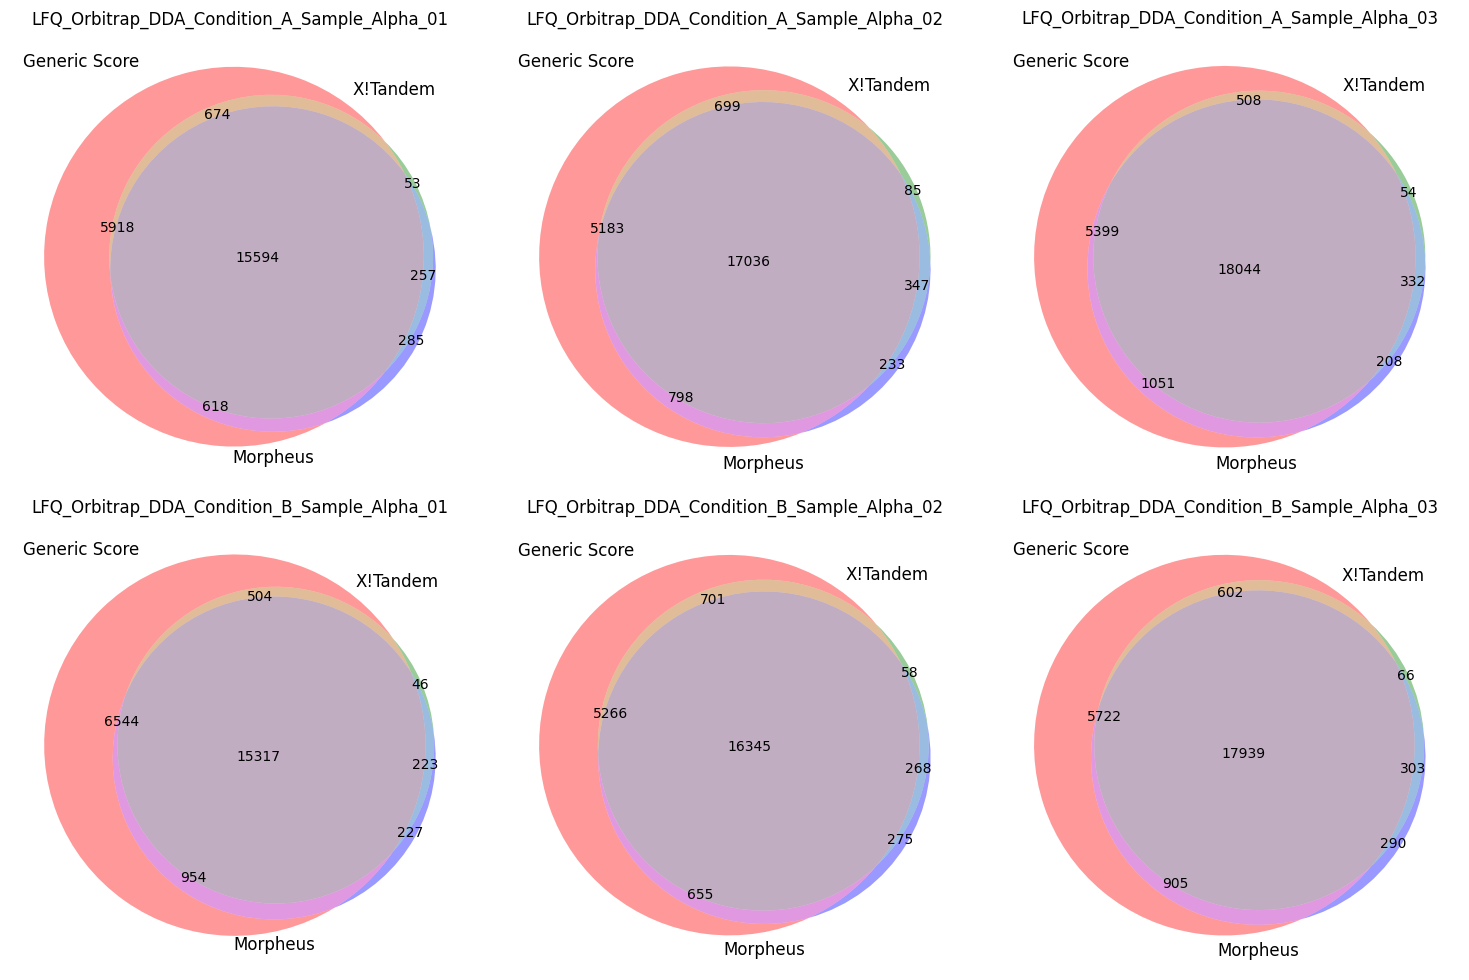

Average Overlap: Set1 98.04 %, Set2 97.00 %, Increase 133.52 %


['LFQ_timsTOFPro_PASEF_Condition_A_Sample_Alpha_01.ms_data.hdf', 'LFQ_timsTOFPro_PASEF_Condition_A_Sample_Alpha_02.ms_data.hdf', 'LFQ_timsTOFPro_PASEF_Condition_A_Sample_Alpha_03.ms_data.hdf', 'LFQ_timsTOFPro_PASEF_Condition_B_Sample_Alpha_01.ms_data.hdf', 'LFQ_timsTOFPro_PASEF_Condition_B_Sample_Alpha_02.ms_data.hdf', 'LFQ_timsTOFPro_PASEF_Condition_B_Sample_Alpha_03.ms_data.hdf']
	 ===File=== 1
--- x! ---
35815 peptides after x! filtering
--- default ---
148956 peptides after default filtering
--- generic ---
150878 peptides after generic filtering
LFQ_timsTOFPro_PASEF_Condition_A_Sample_Alpha_01.ms_data.hdf Set 2: 94.72 % Set 3: 93.15 % Increase 105.02 %
	 ===File=== 2
--- x! ---
35236 peptides after x! filtering
--- default ---
146820 peptides after default filtering
--- generic ---
148638 peptides after generic filtering
LFQ_timsTOFPro_PASEF_Condition_A_Sample_Alpha_02.ms_data.hdf Set 2: 94.86 % Set 3: 92.91 % Increa

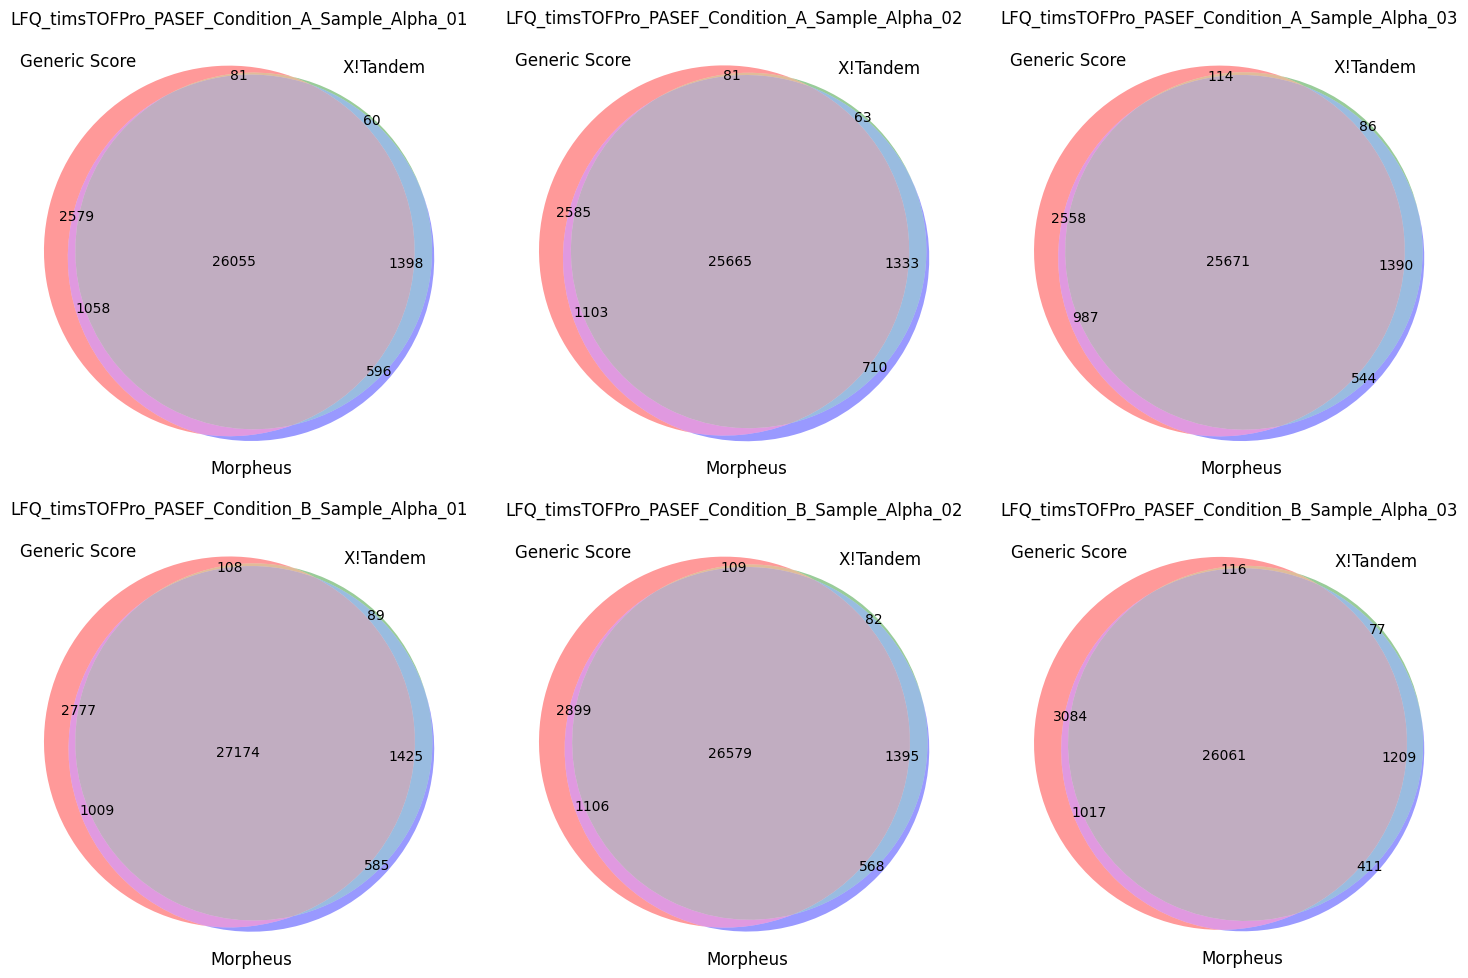

Average Overlap: Set1 94.83 %, Set2 93.40 %, Increase 105.77 %


In [1]:
import os
import numpy as np

import alphapept.io
from alphapept.score import get_ML_features, filter_with_ML, filter_with_x_tandem, cut_global_fdr, train_RF
from matplotlib_venn import venn3
import matplotlib.pyplot as plt


for placeholder in ['Thermo', 'Bruker']:
    
    print('\n')
    
    BASE_DIR = f'F:/AP_Paper_Benchmark/PXD028735/PXD028735_{placeholder}_AlphaPept/'

    data_files = [_ for _ in os.listdir(BASE_DIR) if _.endswith('.ms_data.hdf')]
                  
    print(data_files)
    
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 per row
    axes = axs.flat
    
    fracs1 = []
    fracs2 = []
    increases = []

    
    for idx, ms_file_name in enumerate(data_files):
        
        print(f'\t ===File=== {idx+1}')
        ms_file = os.path.join(BASE_DIR, ms_file_name)
        
        ms_file = alphapept.io.MS_Data_File(ms_file)

        ss = ms_file.read(dataset_name='first_search')
        ss = get_ML_features(ss)

        ml_df = ss.copy()
        x_df = ss.copy()
        d_df = ss.copy()
        g_df = ss.copy()
        
        if False:
            print('--- ML ---')
            cv, features = train_RF(ml_df, plot=True, ini_score = 'generic_score')
            ml_df = filter_with_ML(ml_df, cv, features = features)
            ml_df = cut_global_fdr(ml_df, analyte_level='precursor',  plot=False)

            print(f'{len(ml_df)} peptides after ML filtering')

        print('--- x! ---')
        x_df = filter_with_x_tandem(x_df)
        x_df = cut_global_fdr(x_df, analyte_level='precursor',  plot=False)

        print(f'{len(x_df)} peptides after x! filtering')

        print('--- default ---')
        d_df['score'] = d_df['hits']
        d_df = cut_global_fdr(d_df, analyte_level='precursor',  plot=False)

        print(f'{len(d_df)} peptides after default filtering')

        print('--- generic ---')
        g_df['score'] = g_df['generic_score']
        g_df = cut_global_fdr(g_df, analyte_level='precursor',  plot=False)

        print(f'{len(g_df)} peptides after generic filtering')
        
    
        set1 = set(g_df[g_df['target']]['sequence'])
        set2 = set(x_df[x_df['target']]['sequence'])
        set3 = set(d_df[d_df['target']]['sequence'])

        venn3([set1, set2, set3], ('Generic Score', 'X!Tandem', 'Morpheus'), ax=axes[idx])
        
        intersection_set2 = set1.intersection(set2)
        intersection_set3 = set1.intersection(set3)

        frac1 = len(intersection_set2)/len(set2)
        frac2 = len(intersection_set3)/len(set3)

        increase = len(set1) / ((len(set2) + len(set3))/2)

        print(f'{ms_file_name} Set 2: {frac1*100:.2f} % Set 3: {frac2*100:.2f} % Increase {increase*100:.2f} %')
        
        fracs1.append(frac1)
        fracs2.append(frac2)
        
        increases.append(increase)
        
        axes[idx].set_title(ms_file_name[:-12])
    
    plt.tight_layout()
    plt.savefig(f'figures/SI_02B_{placeholder}.pdf')  

    plt.show()
    
    print(f'Average Overlap: Set1 {np.mean(fracs1)*100:.2f} %, Set2 {np.mean(fracs2)*100:.2f} %, Increase {np.mean(increases)*100:.2f} %')